## Project Description

With climate change the range of flora and fauna are changing. In particular, flat areas, such as those that typify grasslands, are very susceptible to changes in species range change because plants and animals will have to move over long distance to maintain suitable temperatures. Additionally, the water supply in these areas are increasingly stressed by higher evaporation and changing rainfall under warmer temperatures. 


## Study Areas

These two sites were chosen because of their positions within the current range of Sorghastrum nutan: Pawnee National Grassland is at the western edge of the current range while Cimarron National Grassland is surrounded by areas where S. nutan currently grows.


In [1]:
# Import libraries

import logging
import os
import shutil
import subprocess
import pathlib
from glob import glob
import math

import warnings
from IPython.display import display, HTML, Image
import earthpy as et
import earthpy.earthexplorer as etee
import earthpy.appeears as etapp
import folium
import geopandas as gpd
import geoviews as gv
import holoviews as hv
import hvplot.pandas
import hvplot.xarray
import keyring
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray as rxr
import requests
import xarray as xr
from xrspatial import aspect
import rioxarray.merge as rxrmerge

/Users/alexiemillikin/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/geoviews/operation/__init__.py:14: HoloviewsDeprecationWarning: 'ResamplingOperation' is deprecated and will be removed in version 1.18, use 'ResampleOperation2D' instead.
  from holoviews.operation.datashader import (


In [2]:
# Set up logging so AppeearsDownloader will log in notebook
logging.basicConfig(level=logging.INFO)

# Ignore FutureWarning coming from hvplot
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create path to SRTM elevation directory
srtm_dir = os.path.join(et.io.HOME, et.io.DATA_NAME, 'srtm')

# Create SRTM elevation directory
os.makedirs(srtm_dir, exist_ok=True)

In [3]:
# Define url for grassland boundary data
grasslands_url = (
    "https://data.fs.usda.gov/geodata/edw/edw_resources"
    "/shp/S_USA.NationalGrassland.zip"
)

# Load grassland boundary data, set index to grassland name,
# and reproject to same coordinate reference system as other data
grasslands_gdf = (
    gpd.read_file(grasslands_url)
    .set_index('GRASSLANDN')
    .to_crs(epsg=4326)
)

In [4]:
# Creata map of national grasslands

# Define coordinates of study areas for plotting
cim_lat = 37.139418
cim_lon = -101.7941457
paw_lat = 40.7614588
paw_lon = -104.0493284

# Create a Folium map object
grassland_map = folium.Map(
    location=[paw_lat, paw_lon],
    zoom_start=5,
    scrollWheelZoom=False
    )

# Create and add title to map
map_title = "National Grasslands Map"
title_html = (
    f'<h1 style="position:absolute;z-index:100000;left:30vw" >{map_title}</h1>')
grassland_map.get_root().html.add_child(folium.Element(title_html))

# Define style for grasslands outlines
grassland_style = {
    "fillColor": "maroon",
    "color": "black",
    "weight": 0.5,
}

# Convert the GeoDataFrame to GeoJSON format
grasslands_geojson = grasslands_gdf.to_json()

# Create separate feature groups for tile layers
esri_world_imagery_group = (
    folium
    .FeatureGroup(name='ESRI World Imagery', show=False)
)

# Add ESRI World Imagery as a Tile Layer
esri_world_imagery = folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services"
    "/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    overlay=True,
).add_to(esri_world_imagery_group)

# Add feature groups to the map
esri_world_imagery_group.add_to(grassland_map)

# Add grassland boundaries to map as GeoJSON layer
folium.GeoJson(
    grasslands_geojson,
    name='National Grassland',
    style_function=lambda feature: grassland_style
    ).add_to(grassland_map)

# Add markers for study areas
folium.Marker(
    location=[cim_lat, cim_lon],
    popup='Cimarron National Grassland').add_to(grassland_map)

folium.Marker(
    location=[paw_lat, paw_lon],
    popup='Pawnee National Grassland').add_to(grassland_map)

# Add layer control to toggle between different layers
folium.LayerControl(collapsed=False).add_to(grassland_map)

# Display the map
grassland_map

In [5]:
# Select and save Cimarron boundary as own geodataframe
cim_gdf = (
    grasslands_gdf[grasslands_gdf.index == 'Cimarron National Grassland'])

# Select and save Pawnee boundary as own geodataframe
paw_gdf = (
    grasslands_gdf[grasslands_gdf.index == 'Pawnee National Grassland'])

Pawnee National Grassland is located in northeastern Colorado and spans 193,060 acres (40.7614588, -104.0493284). No rivers run through the grasslands but water is accessible in shallow aquifers. Shales and sandstones underly most of the grasslands, and sandstone make up the two Pawnee Buttes. Grasses dominate the vegetation although there are some shurbs and yucca and cottonwoods are present near springs. Elevation ranges from 4300 to 5900 feet. The average January high temperature is 44 °F and the average low is 17°F. Summers are hot and dry. July average high and low of 92 and 59°F, respectively. The annual precipitation is 18 inches and mostly falls in spring. The Pawnee National Grasslands are located on the ancestral homelands of the Cheyenne, Arapaho and Očhéthi Šakówiŋ peoples.

In [6]:
# Creata map for Pawnee National Grassland

# Define coordinates of study area for plotting
paw_lat = 40.7614588
paw_lon = -104.0493284

# Create a Folium map object
pawnee_map = folium.Map(
    location=[paw_lat, paw_lon],
    zoom_start=10,
    scrollWheelZoom=False
    )

# Create and add title to map
map_title = "Pawnee National Grassland Map"
title_html = (
    f'<h1 style="position:absolute;z-index:100000;left:30vw" >{map_title}</h1>')
pawnee_map.get_root().html.add_child(folium.Element(title_html))

# Define style for grasslands outlines
grassland_style = {
    "fillColor": "maroon",
    "color": "black",
    "weight": 0.5,
}

# Convert the GeoDataFrame to GeoJSON format
paw_geojson = paw_gdf.to_json()

# Create feature group for tile layers
esri_world_imagery_group = (
    folium.FeatureGroup(name='ESRI World Imagery', show=False)
)

# Add ESRI World Imagery as a Tile Layer
esri_world_imagery = folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services"
    "/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    overlay=True,
).add_to(esri_world_imagery_group)

# Add feature group to the map
esri_world_imagery_group.add_to(pawnee_map)

# Add the Pawnee boundary data to the map as a GeoJson layer
folium.GeoJson(
    paw_geojson,
    name='National Grassland',
    style_function=lambda feature: grassland_style
    ).add_to(pawnee_map)

# Add layer control to toggle between different layers
folium.LayerControl(collapsed=False).add_to(pawnee_map)

# Display the map
pawnee_map

Cimarron National Grassland is located in southwestern Kansas (37.139418, -101.7941457) and covers 108,175 acres. The landscape comprises sandstone and limestone cliffs with shale bedrock underlying low lying areas. Vegetation includes cottonwoods, prairie grasses, yucca and sagebrush. The elevation ranges from 3,150 to 3,540 feet. The Cimarron River provides water to the area and flows through the grasslands but is usually dry above ground late summer through winter. Winter climate is mild to cold with little snowfall. The average January high temperature is 48 °F and the average low is 21°F. Summers are hot and dry, with a July average high and low of 94 and 65°F, respectively. The annual precipitation is 15 inches and mostly falls from spring to early fall. The Cimarron National Grasslands are located on the ancestral homelands of the Kiowa, Kansa, Osage, Pawnee, Comanche, Očhéthi Šakówiŋ, Arapaho, and Ute peoples.

In [7]:
# Define coordinates of study area for plotting
cim_lat = 37.139418
cim_lon = -101.7941457

# Create a Folium map object
cim_map = folium.Map(
    location=[cim_lat, cim_lon],
    zoom_start=10,
    scrollWheelZoom=False
    )

# Create and add title to map
map_title = "Cimarron National Grassland Map"
title_html = (
    f'<h1 style="position:absolute;z-index:100000;left:30vw" >{map_title}</h1>')
cim_map.get_root().html.add_child(folium.Element(title_html))

# Define style for grasslands outlines
grassland_style = {
    "fillColor": "maroon",
    "color": "black",
    "weight": 0.5,
}

# Convert the GeoDataFrame to GeoJSON format
cim_geojson = cim_gdf.to_json()

# Create separate feature groups for tile layers
esri_world_imagery_group = (
    folium.FeatureGroup(name='ESRI World Imagery', show=False)
)

# Add ESRI World Imagery as a Tile Layer
esri_world_imagery = folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services"
    "/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    overlay=True,
).add_to(esri_world_imagery_group)

# Add feature groups to the map
esri_world_imagery_group.add_to(cim_map)

# Add grassland boundary to map as GeoJSON layer
folium.GeoJson(
    cim_geojson,
    name='National Grassland',
    style_function=lambda feature: grassland_style
    ).add_to(cim_map)

# Add layer control to toggle between different layers
folium.LayerControl(collapsed=False).add_to(cim_map)

# Display the map
cim_map

## POLARIS dataset:
The POLARIS dataset is a 30m spatial resolution predicted soil map of the United States that contains over 9 billion grid cells. The map was constructed by combing environmental data and a machine learning algorithm and is an improvement over it’s predecessor, the Soil Survey Geographic (SSURGO) database, in that uses predictive modelling to fill in unmapped areas. This dataset includes a number of soil variables, including percentage of silt, sand and clay, bulk density, soil water content, soil pH, organic matter content, and measures of pore size. In this analysis we use pH data

### POLARIS citation:
n:
Chaney, N. W., Wood, E. F., McBratney, A. B., Hempel, J. W., Nauman, T. W., Brungard, C. W., & Odgers, N. P. (2016). POLARIS: A 30-meter probabilistic soil series map of the contiguous United States. Geoderma, 274, 54-67.


In [8]:
# Define function to get the bounds of a grassland
def calculate_bounds(gdf):
    """
    Calculates the bounds for data download from POLARIS dataset given a gdf.

    Parameters
    ==========
    gdf : gdf
      Input geodataframe

    Returns
    =======
    east_bound : int
      longitude integer to east of eastern-most point in geodataframe
    south_bound : int
      longitude integer to south of southern-most point in geodataframe
    west_bound : int
      longitude integer to west of western-most point in geodataframe
    north_bound : int
      longitude integer to north of northern-most point in geodataframe
    """
    max_lon, min_lat, min_lon, max_lat = map(abs, gdf.total_bounds)
    east_bound = math.floor(min_lon)
    south_bound = math.floor(min_lat)
    west_bound = math.ceil(max_lon)
    north_bound = math.ceil(max_lat)
    return east_bound, south_bound, west_bound, north_bound

In [9]:
# Create list of two grasslands
two_grasslands_gdf = [cim_gdf, paw_gdf]

# Define name for each dataframe to make variables
cim_gdf.name = "cim"
paw_gdf.name = "paw"

# Execute function to create variables for bounds of grasslands
for gdf in two_grasslands_gdf:
    east_bound, south_bound, west_bound, north_bound = calculate_bounds(gdf)

    # Use globals() to create global variables dynamically
    globals()[f"{gdf.name}_east_bound"] = east_bound
    globals()[f"{gdf.name}_south_bound"] = south_bound
    globals()[f"{gdf.name}_west_bound"] = west_bound
    globals()[f"{gdf.name}_north_bound"] = north_bound

# Access bounding varibales
# cim_north_bound

In [10]:
def generate_pH_urls(south_bound, north_bound, east_bound, west_bound):
    """
    Creates urls for data download from POLARIS dataset: mean pH from 15-30cm depth.

    Data citation:
    Chaney, N. W., Wood, E. F., McBratney, A. B., Hempel, J. W., Nauman, T. W.,
    Brungard, C. W., & Odgers, N. P. (2016).
    POLARIS: A 30-meter probabilistic soil series map of the contiguous United States.
    Geoderma, 274, 54-67.

    Parameters
    ==========
    south_bound : int
      longitude integer to south of southern-most point in geodataframe
    north_bound : int
      longitude integer to north of northern-most point in geodataframe
    east_bound : int
      longitude integer to east of eastern-most point in geodataframe
    west_bound : int
      longitude integer to west of western-most point in geodataframe

    Returns
    =======
    ph_urls : list of str variables
      list of urls to use for data downloads
    """
    pH_urls = []

    for lat in range(south_bound, north_bound):
        for lon in range(east_bound + 1, west_bound + 1):
            url = f"http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/15_30/lat{lat}{lat + 1}_lon-{lon}-{lon-1}.tif"
            pH_urls.append(url)

    return pH_urls

In [13]:
# Run generate_pH_urls function on gdf for each grassland to create url list for download
cim_ph_urls = generate_pH_urls(cim_south_bound, cim_north_bound, cim_east_bound, cim_west_bound)
paw_ph_urls = generate_pH_urls(paw_south_bound, paw_north_bound, paw_east_bound, paw_west_bound)
cim_ph_urls

['http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/15_30/lat3637_lon-102-101.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/15_30/lat3637_lon-103-102.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/15_30/lat3738_lon-102-101.tif',
 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/15_30/lat3738_lon-103-102.tif']

In [14]:
# Download, merge and clip pH data for each grassland
# Download pH data from each grassland's url list
cim_pH_das = [rxr.open_rasterio(url, masked=True).squeeze() for url in cim_pH_urls]
paw_pH_das = [rxr.open_rasterio(url, masked=True).squeeze() for url in paw_pH_urls]

# Merge pH data into one data array for each grassland
cim_merged_pH_da = rxrmerge.merge_arrays(cim_pH_das)
paw_merged_pH_da = rxrmerge.merge_arrays(paw_pH_das)

# Clip the raster data to the bounds of grassland
cim_bound_box = cim_gdf.total_bounds
cim_clipped_pH_da = cim_merged_pH_da.rio.clip_box(*cim_bound_box)

paw_bound_box = paw_gdf.total_bounds
paw_clipped_pH_da = paw_merged_pH_da.rio.clip_box(*paw_bound_box)

NameError: name 'cim_pH_urls' is not defined

In [ ]:
# Plot the Cimarron pH data
plt.figure(figsize=(10, 8))
imshow_obj = cim_clipped_pH_da.plot(cmap='viridis', ax=plt.gca(), add_colorbar=False)
colorbar = plt.colorbar(imshow_obj, label='Soil pH')  # Use imshow_obj directly to create the colorbar
colorbar.mappable.set_clim(cim_clipped_pH_da.min(), cim_clipped_pH_da.max())  # Set colorbar limits
plt.title('Cimarron National Grassland Soil pH at 15-30cm')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Overlay the GeoDataFrame boundary
cim_gdf.boundary.plot(ax=plt.gca(), color='black', linewidth=1.5)

plt.show()

In [ ]:
# Plot the Pawnee pH data
plt.figure(figsize=(10, 8))
imshow_obj = paw_clipped_pH_da.plot(cmap='viridis', ax=plt.gca(), add_colorbar=False)
colorbar = plt.colorbar(imshow_obj, label='Soil pH')  # Use imshow_obj directly to create the colorbar
colorbar.mappable.set_clim(paw_clipped_pH_da.min(), paw_clipped_pH_da.max())  # Set colorbar limits
plt.title('Pawnee National Grassland Soil pH at 15-30cm')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Overlay the GeoDataFrame boundary
paw_gdf.boundary.plot(ax=plt.gca(), color='black', linewidth=1.5)

plt.show()

In [42]:
# Create function for downloading data
def download_srtm_data(ea_dir, download_key, product, layer, start_date, end_date, polygon):
    """
    Download SRTM raster elevation data for a given geometry, start date, and end date.

    Data citation:
    NASA JPL (2013). NASA Shuttle Radar Topography Mission Global 1 arc second [Data set].
    NASA EOSDIS Land Processes Distributed Active Archive Center.
    Accessed 2023-12-11 from https://doi.org/10.5067/MEaSUREs/SRTM/SRTMGL1.003

    Data downloaded from NASA AρρEEARS

    Parameters
    ==========
    ea_dir : str
      path to directory where data will be saved
    download_key : str
      The name used to label the download
    product : str
      Data product to download NASA Shuttle Radar Topography Mission Global 1 arc second
    layer : str
      Digital elevation data (DEM) layer to download
    start_date : str
      The start date as 'MM-DD-YYYY'
    end_date : str
      The end date as 'MM-DD-YYYY'
    polygon : gdf
      Bounds for data donwload

    Returns
    =======
    downloader : earthpy.AppearsDownloader
      Object with information about the download.
    """

    data_dir = os.path.join(ea_dir, download_key)  # Define the data directory path

    # Check if the download directory exists
    if not os.path.exists(data_dir):
        # If it doesn't exist, create the directory and download files
        os.makedirs(data_dir)

        # Define parameters for data download
        elev_downloader = etapp.AppeearsDownloader(
            ea_dir=ea_dir,
            download_key=download_key,
            product=product,
            layer=layer,
            start_date=start_date,
            end_date=end_date,
            polygon=polygon,
        )

    # Download files
        elev_downloader.download_files()

    else:
        print(f"Data already exists in {data_dir}. Skipping download.")

# Set parameters for srtm elevation download
srtm_dir = srtm_dir
product = "SRTMGL1_NC.003"
layer = "SRTMGL1_DEM"
start_date = "02-11-2000"
end_date = "02-21-2000"
paw_download_key = "pawnee-srtm"
cim_download_key = "cimarron-srtm"

Data already exists in /Users/alexiemillikin/earth-analytics/data/srtm/pawnee-srtm. Skipping download.
Data already exists in /Users/alexiemillikin/earth-analytics/data/srtm/cimarron-srtm. Skipping download.


In [ ]:
# Download DEM data for each grassland
download_srtm_data(srtm_dir, paw_download_key, product, layer, start_date, end_date, paw_gdf)
download_srtm_data(srtm_dir, cim_download_key, product, layer, start_date, end_date, cim_gdf)

In [17]:
download_keys = [paw_download_key, cim_download_key]
all_srtm_data = {}

for download_key in download_keys:
    srtm_paths = glob(
        os.path.join(srtm_dir, download_key, 'SRTMGL1_NC.003*', '*.tif')
    )
    srtm_data = [rxr.open_rasterio(srtm_path, masked=True).squeeze() for srtm_path in srtm_paths]
    
    # Assuming the original raster file has CRS information
    with rxr.open_rasterio(srtm_paths[0]) as src:
        srtm_data[0].attrs['crs'] = src.rio.crs
    
    all_srtm_data[download_key] = srtm_data

# Access the DataArrays using the download keys
paw_srtm_data = all_srtm_data[paw_download_key][0]
cim_srtm_data = all_srtm_data[cim_download_key][0]

# Print CRS information
print("Pawnee National Grassland Soil pH Data CRS:", paw_srtm_data.rio.crs)
print("Cimarron Soil pH Data CRS:", cim_srtm_data.rio.crs)

Pawnee National Grassland Soil pH Data CRS: EPSG:4326
Cimarron Soil pH Data CRS: EPSG:4326


In [18]:
cim_srtm_data_clip = cim_srtm_data.rio.clip(cim_gdf.geometry)
paw_srtm_data_clip = paw_srtm_data.rio.clip(paw_gdf.geometry)

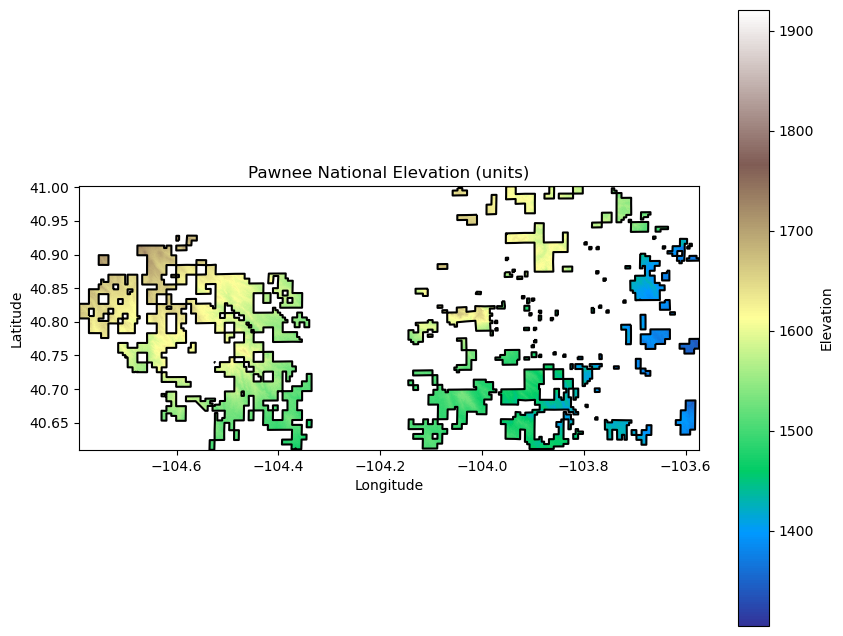

In [19]:
# Plot the Pawnee elevation data
plt.figure(figsize=(10, 8))
imshow_obj = paw_srtm_data_clip.plot(cmap='terrain', ax=plt.gca(), add_colorbar=False)
colorbar = plt.colorbar(imshow_obj, label='Elevation')  # Use imshow_obj directly to create the colorbar
colorbar.mappable.set_clim(paw_srtm_data.min(), paw_srtm_data.max())  # Set colorbar limits
plt.title('Pawnee National Elevation (units)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Overlay the GeoDataFrame boundary
paw_gdf.boundary.plot(ax=plt.gca(), color='black', linewidth=1.5)

plt.show()

In [26]:
maca_url = "http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_macav2metdata_pr_MRI-CGCM3_r1i1p1_historical_1950_2005_CONUS_monthly.nc?var=precipitation&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start=1980-01-15T00%3A00%3A00Z&time_end=1980-12-15T00%3A00%3A00Z&timeStride=1&accept=netcdf"

maca_response = requests.get(maca_url)
with open('maca.nc', 'wb') as maca_file:
    maca_file.write(maca_response.content)

In [50]:
maca_ds = xr.open_dataset('maca.nc')
maca_ds = maca_ds.assign_coords(lon=maca_ds.lon-360)
hist_precip_da = maca_ds.precipitation
hist_precip_da.rio.write_crs("epsg:4326", inplace=True)
hist_precip_da.rio.set_spatial_dims('lon', 'lat', inplace=True)

hist_precip_da.mean('time').hvplot(rasterize=True)

:DynamicMap   []
   :Overlay
      .Image.I    :Image   [lon,lat]   (precipitation)
      .Polygons.I :Polygons   [x,y]

In [51]:
hist_precip_da.rio.clip_box(*cim_gdf.total_bounds).mean('time').hvplot()*cim_gdf.hvplot()

:Overlay
   .Image.I    :Image   [lon,lat]   (precipitation)
   .Polygons.I :Polygons   [x,y]